In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import scipy

In [116]:
# Load in csv file
path_to_ssl = '/mnt/c/PythonScripts/segp/github_version/'
relative_path = 'SSL/results/full_data.csv'
fpath = path_to_ssl + relative_path
df = pd.read_csv(fpath, index_col = False)
print(df.columns)

Index(['Models', 'few shot shenzhencxr', 'few shot shenzhencxr uncertainty',
       'few shot montgomerycxr', 'few shot montgomerycxr uncertainty',
       'few shot bach', 'few shot bach uncertainty', 'few shot iChallengeAMD',
       'few shot iChallengeAMD uncertainty', 'few shot iChallengePM',
       'few shot iChallengePM uncertainty', 'few shot chexpert',
       'few shot chexpert uncertainty', 'few shot stoic',
       'few shot stoic uncertainty', 'few shot diabetic retinopathy (5way)',
       'few shot diabetic retinopathy (5way) uncertainty',
       'few shot chestx (5way)', 'few shot chestx (5way) uncertainty',
       'few shot cifar10 (2way)', 'few shot cifar10 (2way) uncertainty',
       'few shot cifar10 (5way)', 'few shot cifar10 (5way) uncertainty',
       'imagenet top1', 'linear chexpert', 'linear diabetic retinopathy',
       'finetune chexpert', 'finetune diabetic retinopathy',
       'attentive diffusion shenzhencxr', 'attentive diffusion montgomerycxr',
       'atten

In [130]:
# Model names
models = ["simclrv1","mocov2","swav","byol","pirl","supervised r50",
        "supervised r18","supervised d121","mimic-chexpert lr=0.01",
        "mimic-chexpert lr=0.1","mimic-chexpert lr=1.0","mimic-cxr r18",
        "mimic-cxr d121"]

# Base dataset names
medical_datasets = ["shenzhencxr","montgomerycxr","bach","iChallengeAMD",
                "iChallengePM","chexpert","stoic","diabetic retinopathy (5way)",
                "chestx (5way)","cifar10 (2way)"]

# All experiment names
experiment_types = ["few shot", "linear", "finetune", "attentive diffusion", 
        "invariance rotation", "invariance hflip", "invariance hue", 
        "perceptual distance alexnet", "perceptual distance vgg",
        "perceptual distance squeezenet"]

def check_if_experiment_exists(df,experiment_type, medical_dataset):
    """Check if an experiment is done with a specific medical dataset"""
    column_name = experiment_type + " " + medical_dataset
    if column_name in df.columns:
        return True
    else:
        return False

def check_which_models_experiment_exists_for(df,column_name):
    experiment = df.loc[:,[column_name]]
    not_contained_indices = experiment.index[experiment.isnull().all(1)].values
    return list(not_contained_indices)

def extract_cleaned_dataframe(df, column_names):
    # column_names should be a list of existing column_names
    new_df = df.loc[:,tuple(column_names)]
    missing_indices = []
    for column in column_names:
        missing_indices = missing_indices + check_which_models_experiment_exists_for(df,column)
    # remove duplicates
    missing_indices = list(set(missing_indices))
    missing_indices.sort(reverse = True)
    for index in missing_indices:
        new_df.drop(index, inplace = True)
    return new_df

def get_few_shot_uncertainty(full_df,list_of_experiment_types, list_of_medical_datasets, column_names):
    if "few shot" in list_of_experiment_types:
        for dataset in list_of_medical_datasets:
            column_name = "few shot " + dataset + " uncertainty"
            if column_name in full_df.columns:
                column_names.append(column_name)
    return column_names

def clean_dataframe(full_df, list_of_experiment_types, list_of_medical_datasets,imagenet = True,sns_utils = True):
    """The imagenet keyword decides whether imagenet top1 column is included"""
    column_names = []
    for experiment in list_of_experiment_types:
        for medical_dataset in list_of_medical_datasets:
            if check_if_experiment_exists(full_df,experiment, medical_dataset):
                column_name = experiment + " " + medical_dataset
                column_names.append(column_name)
            else:
                raise KeyError('Problem with the lists given, some combinations do not give valid column names')
    if imagenet:
        column_names.append("imagenet top1")
    if sns_utils:
        column_names.append("Models")
        column_names.append("Model Type")
        column_names.append("Marker Size")
    column_names = get_few_shot_uncertainty(full_df,list_of_experiment_types, list_of_medical_datasets, column_names)
    #print(full_df)
    new_df = extract_cleaned_dataframe(full_df, column_names)
    #print(new_df)
    return new_df  

def normalize_list(a_list):
    min_val = min(a_list)
    max_val = max(a_list)
    for i in range(len(a_list)):
        a_list[i] = (a_list[i]-min_val)/(max_val-min_val)
    return a_list, 1/(max_val-min_val)

In [153]:
def plot_scatter_plt(df, x_column_name, y_column_name, y_error_column_name, color, scaled = False):
    x = np.squeeze(df.loc[:,[x_column_name]].values).tolist()
    if scaled:
        y,scaler = normalize_list(np.squeeze(df.loc[:,[y_column_name]].values).tolist())
        y_error = np.squeeze(df.loc[:,[y_error_column_name]].values).tolist()
        for i in range(len(y_error)):
            y_error[i] = y_error[i]*scaler
    else:
        y_error = np.squeeze(df.loc[:,[y_error_column_name]].values).tolist()
        y = np.squeeze(df.loc[:,[y_column_name]].values).tolist()
    plt.errorbar(x,y,yerr = y_error,label='astar',ms=5, fmt = "o", color = color)
    plt.ylabel("Few-shot Transfer Accuracy")
    plt.xlabel("ImageNet Top-1 Accuracy")
    return x, y, y_error
    #plt.savefig(datasets[i]+"figure.jpg", bbox_inches = "tight")

def get_vals_in_lists(df,x_column_name, y_column_name, y_error_column_name):
    y_error = np.squeeze(df.loc[:,[y_error_column_name]].values).tolist()
    y = np.squeeze(df.loc[:,[y_column_name]].values).tolist()
    x = np.squeeze(df.loc[:,[x_column_name]].values).tolist()
    return x, y , y_error

def plot_scatter_sns(df, x_column_name, y_column_name, y_error_column_name):
    y_error = np.squeeze(df.loc[:,[y_error_column_name]].values).tolist()
    g = sns.relplot(x=x_column_name, y=y_column_name, data=clean_df, hue = "Models", 
                    palette="tab10", style = "Model Type", size = "Marker Size", 
                    sizes = (50,51))
    g.map(plt.errorbar,x_column_name,y_column_name, 
        yerr=np.squeeze(df.loc[:,[y_error_column_name]].values).tolist(), 
        fmt=' ', zorder=-1, label = df["Models"].to_list(), ecolor = "black")  
    plt.ylabel("Few-shot Transfer Accuracy")
    plt.xlabel("ImageNet Top-1 Accuracy")
    #plt.savefig(datasets[i]+"figure.jpg", bbox_inches = "tight")

def fit_regression_line(x,y,yerr):
    popt, pcov = scipy.optimize.curve_fit(linear_function,x,y,sigma = yerr)
    perr = np.sqrt(np.diag(pcov))
    return popt[0],popt[1], perr

def plot_single_line(x,m,c):
    line_vals = []
    for x_val in x:
        line_vals.append(linear_function(x_val,m,c))
    plt.plot(x,line_vals, color = "black", zorder = -1)
    return line_vals

def find_and_plot_linear(x,y,yerr):
    m,c,param_errs = fit_regression_line(x,y,yerr)
    y_pred = plot_single_line(x,m,c)
    r,p_val = scipy.stats.pearsonr(x,y)
    chi2_reduced = calculate_chisquare(y,y_pred,yerr)
    print(f"Fit line with m = {m} +- {param_errs[0]} and c = {c} +- {param_errs[1]}")
    print(f"Pearsons r (and p value): {r}, {p_val}; Reduced Chi-Squared: {chi2_reduced}")
    return None

def calculate_chisquare(y,y_pred,yerr):
    chi_squared = 0
    res= []
    for i in range(len(y)):
        chi_squared += ((y_pred[i]-y[i])/yerr[i])**2
        res.append((-y_pred[i]+y[i])/yerr[i])
    return chi_squared/2

def linear_function(x,m,c):
    return m*x+c

def plot_multiple(df, x_column_name, y_columns_list, sns_plot = True, together = True):
    sns.set_style("ticks")
    if sns_plot:
        for i in range(len(y_columns_list)):
            plot_scatter_sns(df, x_column_name,y_columns_list[i], y_columns_list[i]+" uncertainty")
            if not together:
                plt.show()
    else:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        for i in range(len(y_columns_list)):
            x,y,yerr = get_vals_in_lists(df,x_column_name, y_columns_list[i], y_columns_list[i]+" uncertainty")
            plot_scatter_plt(df, x_column_name,y_columns_list[i], y_columns_list[i]+" uncertainty", colors[0], scaled = False)
            find_and_plot_linear(x,y,yerr)
            if not together:
                    plt.show()
    plt.show()



Fit line with m = -0.2639412975216445 +- 0.11508566028464172 and c = 0.9352734262370446 +- 0.08265756053373595
Pearsons r (and p value): -0.6722548649229756, 0.06779704152664838; Reduced Chi-Squared: 16.795626216840603


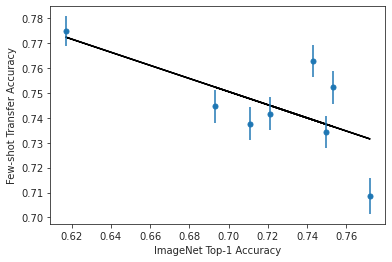

Fit line with m = 0.19465075624530292 +- 0.25294791096177505 and c = 0.5104260987349503 +- 0.18313206311248986
Pearsons r (and p value): 0.2905173976369041, 0.48515354091455026; Reduced Chi-Squared: 56.954885289308955


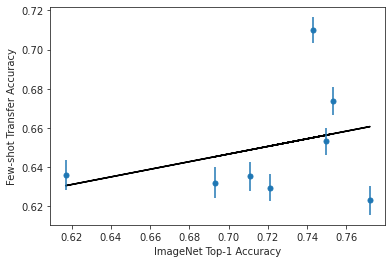

Fit line with m = 0.05317676176056385 +- 0.09044457321199949 and c = 0.7780245849927696 +- 0.065376058522474
Pearsons r (and p value): 0.22766868748665364, 0.5876427828066578; Reduced Chi-Squared: 8.637876404323993


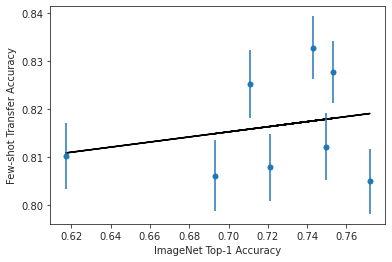

Fit line with m = -0.03163106542983596 +- 0.13894116286152644 and c = 0.770949419233838 +- 0.10005812174999278
Pearsons r (and p value): -0.11369861965428948, 0.7886452438058663; Reduced Chi-Squared: 25.783169216598026


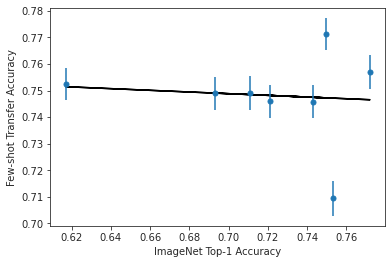

Fit line with m = 0.09776822508642817 +- 0.05403588681088182 and c = 0.8758231240472922 +- 0.03915916585273391
Pearsons r (and p value): 0.6146199126095855, 0.10491933123677155; Reduced Chi-Squared: 12.81909239844912


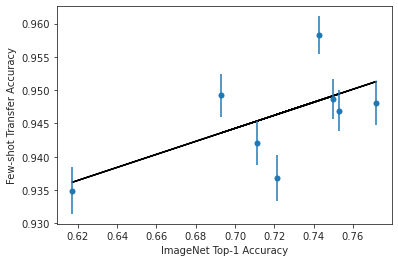

Fit line with m = -0.12898311103957077 +- 0.07315328117481612 and c = 0.6717918652780648 +- 0.052734482257185376
Pearsons r (and p value): -0.5890226829906378, 0.1244442176093461; Reduced Chi-Squared: 4.633125155704989


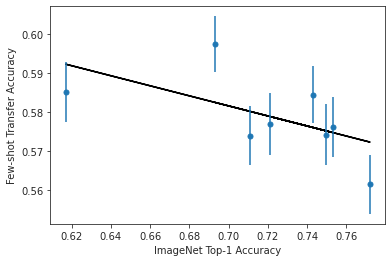

Fit line with m = 0.09942340436128971 +- 0.05299670855575512 and c = 0.44635084448742507 +- 0.038183012547446805
Pearsons r (and p value): 0.5974707237245016, 0.11779169777502771; Reduced Chi-Squared: 2.642101255409933


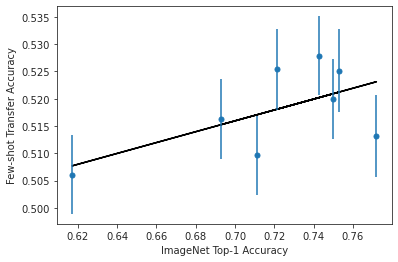

Fit line with m = -0.07948750087448682 +- 0.07594827342649087 and c = 0.39092166937311923 +- 0.05473608018333044
Pearsons r (and p value): -0.39150600826910936, 0.337488055185562; Reduced Chi-Squared: 16.70189824440834


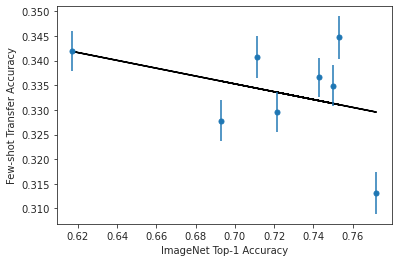

Fit line with m = -0.04894822039848447 +- 0.0756672760466628 and c = 0.32159805306299805 +- 0.05455158055018552
Pearsons r (and p value): -0.2554855380180458, 0.5414017654700082; Reduced Chi-Squared: 14.454539515022754


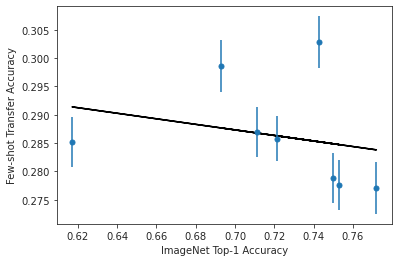

Fit line with m = 0.3394267364808506 +- 0.09798600332507117 and c = 0.6786824690210614 +- 0.0715785525960739
Pearsons r (and p value): 0.8347104587557093, 0.009936270807187354; Reduced Chi-Squared: 11.286296174031738


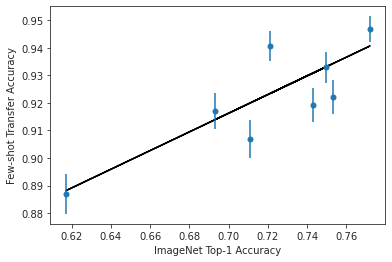

In [154]:
clean_df = clean_dataframe(df, ["few shot"], medical_datasets, imagenet = True)
datasets = ['few shot shenzhencxr', 'few shot montgomerycxr', 'few shot bach',
       'few shot iChallengeAMD', 'few shot iChallengePM', 'few shot chexpert',
       'few shot stoic', 'few shot diabetic retinopathy (5way)',
       'few shot chestx (5way)', 'few shot cifar10 (2way)']

plot_multiple(clean_df, "imagenet top1", datasets, sns_plot = False, together = False)


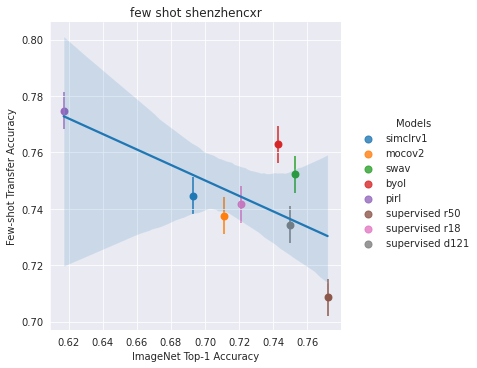

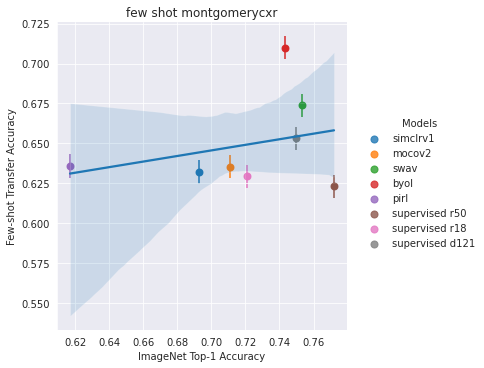

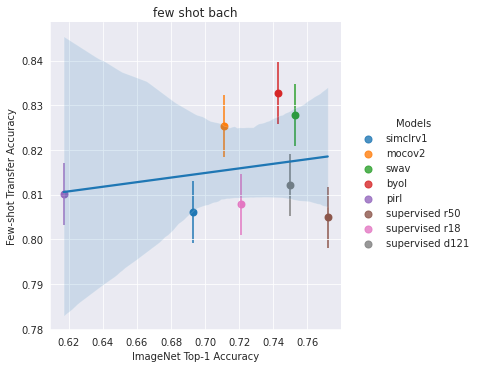

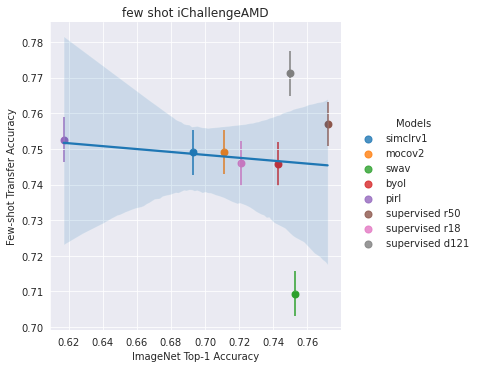

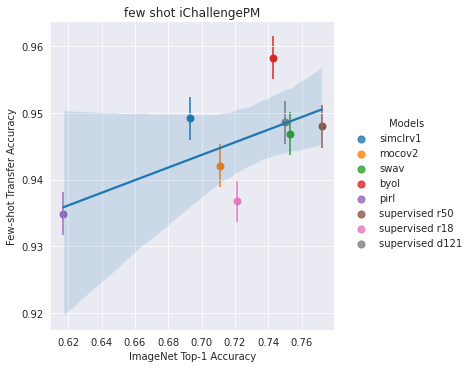

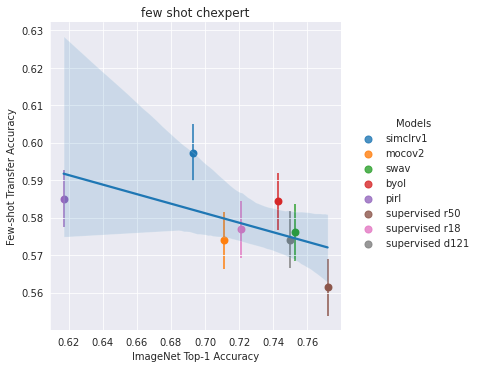

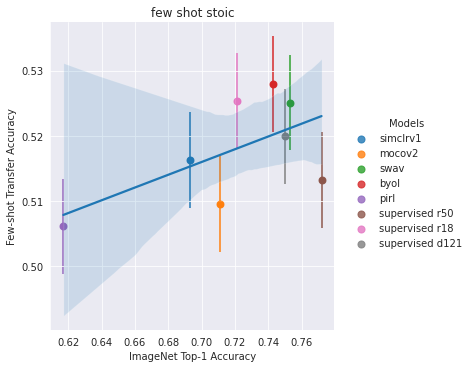

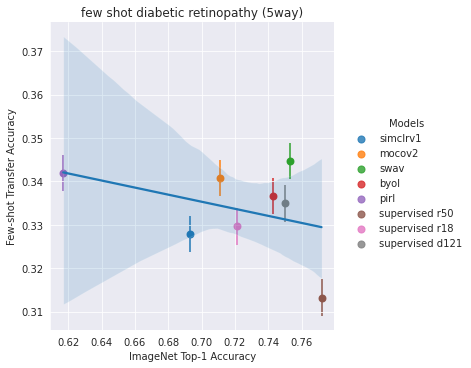

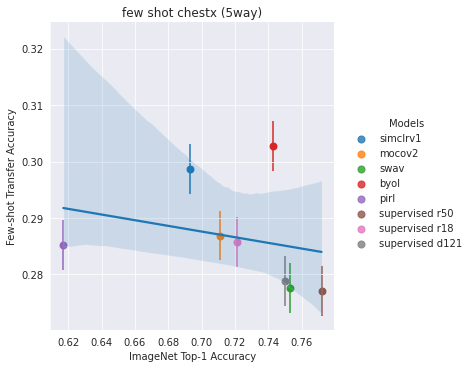

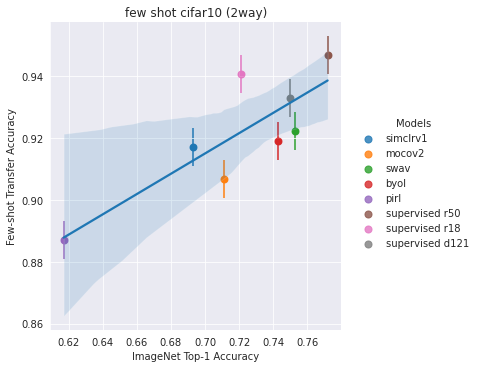

In [ ]:


datasets = ['few shot shenzhencxr', 'few shot montgomerycxr', 'few shot bach',
       'few shot iChallengeAMD', 'few shot iChallengePM', 'few shot chexpert',
       'few shot stoic', 'few shot diabetic retinopathy (5way)',
       'few shot chestx (5way)', 'few shot cifar10 (2way)']

for i in range(len(datasets)):
    sns.set_style("darkgrid")
    markers=['x', 'D', 's', '<', '>', 'v', 'X', '+'] #'P'], '4', 'p', '|']
    g = sns.lmplot(x="imagenet top1", y=datasets[i], data=clean_df, fit_reg=False, hue = "Models",palette="tab10", scatter_kws={"s": 50})
    g.map(plt.errorbar,"imagenet top1",datasets[i], yerr=clean_df[datasets[i]+" uncertainty"].to_numpy().mean(), fmt=' ', zorder=-1, label = clean_df["Models"].to_list())
    sns.regplot(x="imagenet top1", y=datasets[i], data=clean_df, scatter=False, ax=g.axes[0, 0])
    plt.ylabel("Few-shot Transfer Accuracy")
    plt.xlabel("ImageNet Top-1 Accuracy")
    plt.title(datasets[i])
    plt.savefig(datasets[i]+"figure.jpg", bbox_inches = "tight")  

In [ ]:
plot_dset('./few-shot/ichallenge_pm.csv', 'iChallenge-PM')

NameError: name 'plot_dset' is not defined

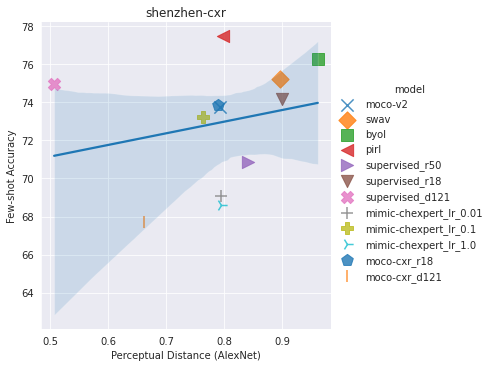

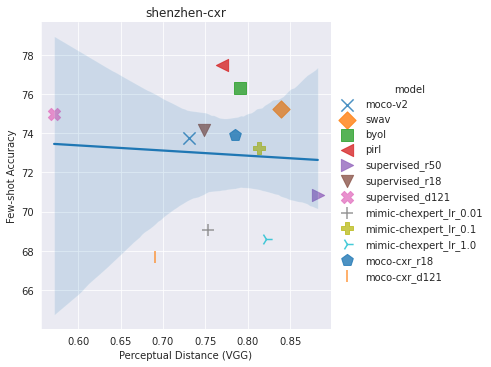

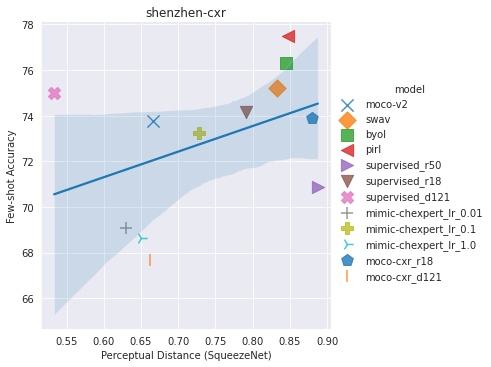

In [ ]:
plot_dset('./few-shot/shenzhencxr.csv', 'shenzhen-cxr')

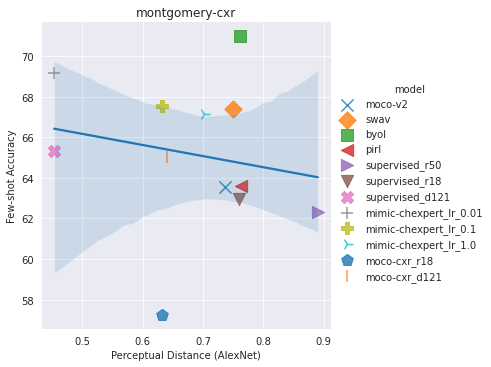

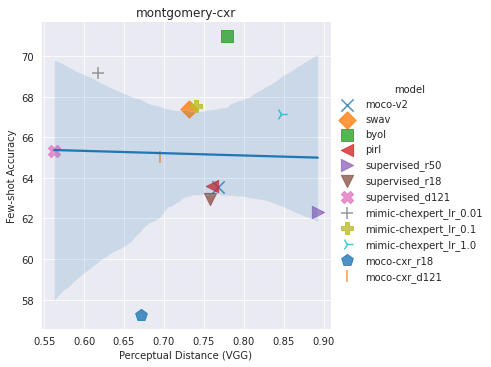

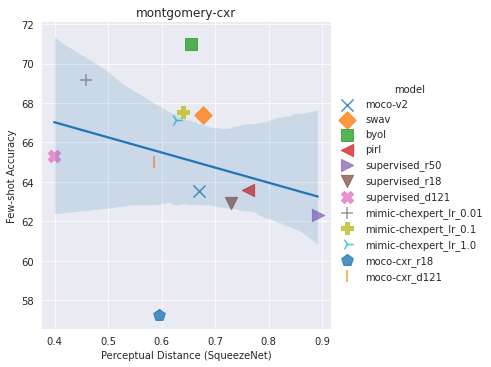

In [ ]:
plot_dset('./few-shot/montgomerycxr.csv', 'montgomery-cxr')

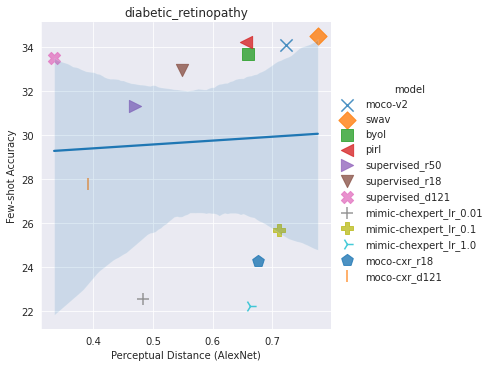

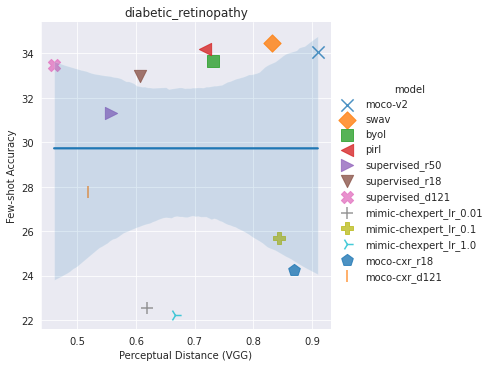

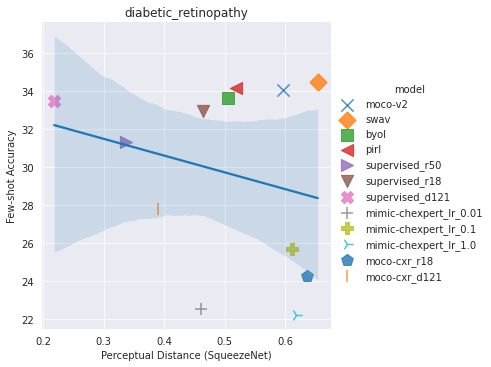

In [ ]:
plot_dset('./few-shot/diabetic_retinopathy.csv', 'diabetic_retinopathy')

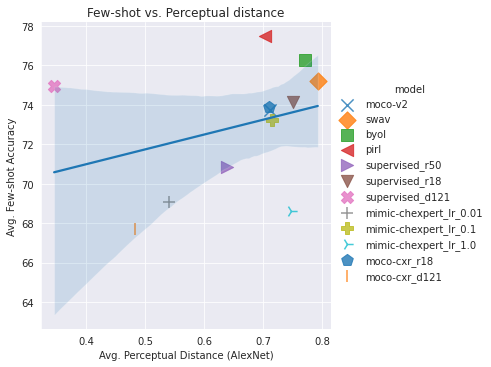

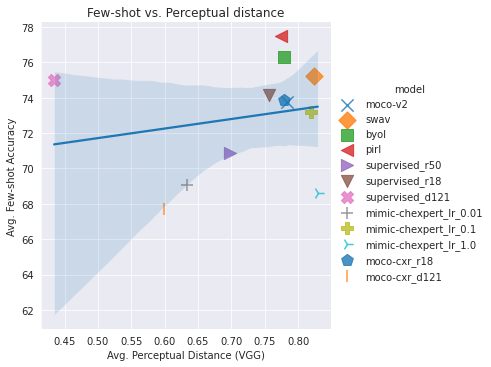

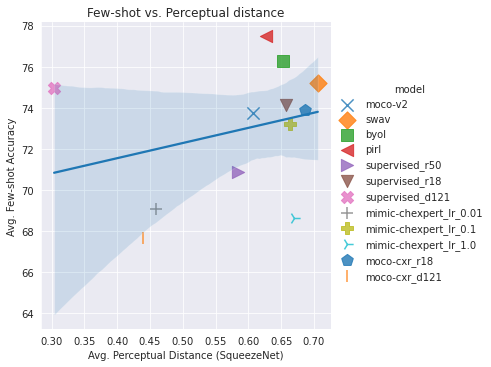

In [ ]:
# plot average across all datasets
dsets = [('diabetic_retinopathy', 'diabetic_retinopathy'), ('ichallenge_amd', 'iChallenge-AMD'),
 ('ichallenge_pm', 'iChallenge-PM') , ('montgomerycxr', 'montgomery-cxr'), ('shenzhencxr', 'shenzhen-cxr')]

average_acc = {}
for i, (dset_name, dset_title) in enumerate(dsets):

    fpath = f'./few-shot/{dset_name}.csv'
    df = pd.read_csv(fpath, index_col=False)
    dset_acc = df.set_index('model').to_dict()['acc']
    for model, acc in dset_acc.items():
        average_acc.setdefault(model, []).append(acc)

for model in average_acc.keys():
    average_acc[model] = np.mean(average_acc[model])



# AlexNet
avg_perceptual_distance_alexnet = {}
for dset, accs in alexnet_dict.items():
    for model, acc in accs.items():
        avg_perceptual_distance_alexnet.setdefault(model, []).append(acc)
for model in avg_perceptual_distance_alexnet.keys():
    avg_perceptual_distance_alexnet[model] = np.mean(avg_perceptual_distance_alexnet[model])


shared_models = dset_acc.keys() and avg_perceptual_distance_alexnet.keys()
dict_intersection = {k: (dset_acc[k], avg_perceptual_distance_alexnet[k]) for k in shared_models}
new_df = pd.DataFrame.from_dict(dict_intersection, orient='index')
new_df = new_df.reset_index(level=0)
new_df.columns = ['model', 'few_shot', 'perceptual_distance']

sns.set_style("darkgrid")
markers=['x', 'D', 's', '<', '>', 'v', 'X', '+', 'P', '4', 'p', '|']
g = sns.lmplot(x="perceptual_distance", y="few_shot", hue="model", data=new_df, fit_reg=False, markers=markers, palette="tab10", scatter_kws={"s": 150})
sns.regplot(x="perceptual_distance", y="few_shot", data=new_df, scatter=False, ax=g.axes[0, 0])
plt.xlabel("Avg. Perceptual Distance (AlexNet)")
plt.ylabel("Avg. Few-shot Accuracy")
plt.title("Few-shot vs. Perceptual distance")
plt.show()




# VGG
avg_perceptual_distance_vgg = {}
for dset, accs in vgg_dict.items():
    for model, acc in accs.items():
        avg_perceptual_distance_vgg.setdefault(model, []).append(acc)
for model in avg_perceptual_distance_vgg.keys():
    avg_perceptual_distance_vgg[model] = np.mean(avg_perceptual_distance_vgg[model])


shared_models = dset_acc.keys() and avg_perceptual_distance_vgg.keys()
dict_intersection = {k: (dset_acc[k], avg_perceptual_distance_vgg[k]) for k in shared_models}
new_df = pd.DataFrame.from_dict(dict_intersection, orient='index')
new_df = new_df.reset_index(level=0)
new_df.columns = ['model', 'few_shot', 'perceptual_distance']

sns.set_style("darkgrid")
markers=['x', 'D', 's', '<', '>', 'v', 'X', '+', 'P', '4', 'p', '|']
g = sns.lmplot(x="perceptual_distance", y="few_shot", hue="model", data=new_df, fit_reg=False, markers=markers, palette="tab10", scatter_kws={"s": 150})
sns.regplot(x="perceptual_distance", y="few_shot", data=new_df, scatter=False, ax=g.axes[0, 0])
plt.xlabel("Avg. Perceptual Distance (VGG)")
plt.ylabel("Avg. Few-shot Accuracy")
plt.title("Few-shot vs. Perceptual distance")
plt.show()




# SqueezeNet
avg_perceptual_distance_squeezenet = {}
for dset, accs in squeezenet_dict.items():
    for model, acc in accs.items():
        avg_perceptual_distance_squeezenet.setdefault(model, []).append(acc)
for model in avg_perceptual_distance_squeezenet.keys():
    avg_perceptual_distance_squeezenet[model] = np.mean(avg_perceptual_distance_squeezenet[model])


shared_models = dset_acc.keys() and avg_perceptual_distance_squeezenet.keys()
dict_intersection = {k: (dset_acc[k], avg_perceptual_distance_squeezenet[k]) for k in shared_models}
new_df = pd.DataFrame.from_dict(dict_intersection, orient='index')
new_df = new_df.reset_index(level=0)
new_df.columns = ['model', 'few_shot', 'perceptual_distance']

sns.set_style("darkgrid")
markers=['x', 'D', 's', '<', '>', 'v', 'X', '+', 'P', '4', 'p', '|']
g = sns.lmplot(x="perceptual_distance", y="few_shot", hue="model", data=new_df, fit_reg=False, markers=markers, palette="tab10", scatter_kws={"s": 150})
sns.regplot(x="perceptual_distance", y="few_shot", data=new_df, scatter=False, ax=g.axes[0, 0])
plt.xlabel("Avg. Perceptual Distance (SqueezeNet)")
plt.ylabel("Avg. Few-shot Accuracy")
plt.title("Few-shot vs. Perceptual distance")
plt.show()



